In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss, roc_auc_score, make_scorer

pd.set_option("display.max_columns",150)

import tensorflow
import xgboost

#### Предобработка данных

Грузим и визуализируем данные

In [3]:
all_data = pd.read_csv("telco-customer-churn.csv")

print (all_data.shape)

for col_name in all_data.columns.values:
    all_unique = all_data[col_name].unique()
    print (col_name, len(all_unique), all_unique[0:5])

(20468, 29)
age 68 [12 42 58 20 36]
annualincome 9508 [168147  29047  27076 137977 136006]
calldroprate 8 [ 0.06  0.05  0.07  0.    0.01]
callfailurerate 4 [ 0.    0.01  0.02  0.03]
callingnum 9525 [4251078442 4251043419 4251055773 4251042488 4251073177]
customerid 9525 [1 2 3 4 5]
customersuspended 2 ['Yes' 'No']
education 4 ['Bachelor or equivalent' 'Master or equivalent' 'PhD or equivalent'
 'High School or below']
gender 2 ['Male' 'Female']
homeowner 2 ['Yes' 'No']
maritalstatus 2 ['Single' 'Married']
monthlybilledamount 120 [71  8 16 74 81]
noadditionallines 1 ['\\N']
numberofcomplaints 4 [0 1 3 2]
numberofmonthunpaid 8 [7 4 2 5 0]
numdayscontractequipmentplanexpiring 100 [96 14 55 73 32]
occupation 3 ['Technology Related Job' 'Non-technology Related Job' 'Others']
penaltytoswitch 500 [371  43 403  76 436]
state 50 ['WA' 'WI' 'KS' 'KY' 'ND']
totalminsusedinlastmonth 500 [ 15 212 216 412 416]
unpaidbalance 250 [ 19  34 144 159 143]
usesinternetservice 2 ['No' 'Yes']
usesvoiceservic

In [4]:
def plot_col (col_name):
    try:
        dt_plot = all_data.groupby(col_name).agg({'age':'count', 'churn': 'sum'}).reset_index().rename(columns={'age':'rec_count'})
    except: ## for age column
        dt_plot = all_data.groupby(col_name).agg({'annualincome':'count', 'churn': 'sum'}).reset_index().rename(columns={'annualincome':'rec_count'})
        
    ## for string columns
    if type(dt_plot[col_name][0]) is str:
        aa = LabelEncoder()
        dt_plot[col_name] = aa.fit_transform(dt_plot[col_name])
        
    dt_plot['churn_perc'] = dt_plot['churn'] / dt_plot['rec_count']
    print (dt_plot.head())

    plt.plot(dt_plot[col_name],dt_plot['churn_perc'])
    plt.show()


   state  rec_count  churn  churn_perc
0      0        461     37    0.080260
1      1        334     17    0.050898
2      2        337     37    0.109792
3      3        450     46    0.102222
4      4        449     63    0.140312


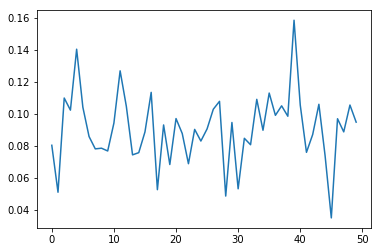

In [5]:
plot_col('state')

Удаляем колонки с годом, месяцев и номером телефона. Они не должны влиять на уровень churn. Но будем иметь в виду, что данные для каждого номера даны за несколько месяцев.

In [6]:
all_data.drop(['year','month','callingnum','customerid','noadditionallines'],axis=1,inplace=True)

Обрабатываем бинарные переменные

In [7]:
bin_cols = ['customersuspended','gender','homeowner','maritalstatus','usesinternetservice','usesvoiceservice']
for col_name in bin_cols:
    unique_val = all_data[col_name].unique()[0]
    all_data[col_name+"__"+unique_val] = 0
    all_data.loc[all_data[col_name]==unique_val,col_name+"__"+unique_val] = 1
    all_data.drop(col_name, axis = 1, inplace=True)

Обрабатываем остальные категорийные переменные

In [8]:
cd_cols = ['education','occupation','state']
all_data_cat = []
for col_name in cd_cols:
    aa = pd.get_dummies(all_data[col_name])
    aa.columns = [col_name+"__"+x for x in aa.columns.values]
    all_data_cat.append(aa)
all_data_cat = pd.concat(all_data_cat,axis=1)

In [9]:
all_data.drop(['education','occupation','state'],axis=1,inplace=True)
all_data = pd.concat([all_data,all_data_cat],axis=1)
print (all_data.shape)

(20468, 78)


### Create model

Делаем K-fold кросс валидацию

In [10]:
X = all_data.drop('churn',axis=1).copy(deep=True)
y = np.array(all_data['churn'])

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.30, random_state=101,shuffle=True)
kf = KFold(n_splits=4,random_state=102)

print (np.sum(y),np.sum(y_train),np.sum(y_valid))

1863 1295 568


#### Регрессия Риджа

ROC AUC: 0.647715803131 <br>
Neg log loss: -


In [76]:
rdg = Ridge(alpha=1.0, fit_intercept=True, normalize = False, max_iter = 10)
cv_score = cross_val_score(rdg, X_train, y_train, cv = kf, n_jobs = -1, scoring = 'roc_auc')

print (cv_score, np.mean(cv_score))

[ 0.63670767  0.66326804  0.62788494  0.66300256] 0.647715803131


In [77]:
print (cv_score, np.mean(cv_score))

[ 0.63670767  0.66326804  0.62788494  0.66300256] 0.647715803131


#### Деревья решений

ROC AUC: 0.973622 <br>
Neg log loss: 0.095319

In [78]:
et_clf = ExtraTreesClassifier(n_estimators = 100, criterion = 'entropy',max_depth=None,
                              min_samples_leaf = 1, random_state = 103, n_jobs=-1)

et_clf.fit(X_train,y_train)

y_pred = et_clf.predict_proba(X_valid)
y_pred = [x[1] for x in y_pred]
print ("")
print ("ROC AUC: %f " % roc_auc_score(y_valid,y_pred))
print ("Neg log loss: %f " % log_loss(y_valid,y_pred))


ROC AUC: 0.973622 
Neg log loss: 0.095319 


Анализ значимых переменных. Самая значимая переменная - штат CO. Сила фактора вызывает сомнение, потому что этот штат влияет намного сильнее, чем остальные штаты.

In [14]:
importances = et_clf.feature_importances_
indices = np.argsort(importances[::-1])

tree_cols = X_train.columns.values[indices]
for k, indx in enumerate(indices[:30]):
    print ("%d. feature %s (%f)" % (k,tree_cols[indx], importances[indx]))

0. feature state__CO (0.041036)
1. feature age (0.004547)
2. feature percentagecalloutsidenetwork (0.018801)
3. feature callfailurerate (0.004219)
4. feature numdayscontractequipmentplanexpiring (0.006072)
5. feature state__MN (0.012812)
6. feature state__HI (0.004751)
7. feature state__OK (0.004961)
8. feature state__DE (0.003575)
9. feature usesvoiceservice__No (0.037266)
10. feature state__KS (0.018154)
11. feature homeowner__Yes (0.006102)
12. feature calldroprate (0.002966)
13. feature customersuspended__Yes (0.020054)
14. feature state__GA (0.040591)
15. feature totalcallduration (0.004060)
16. feature occupation__Non-technology Related Job (0.007786)
17. feature penaltytoswitch (0.005346)
18. feature state__AZ (0.005035)
19. feature state__ID (0.004115)
20. feature totalminsusedinlastmonth (0.004871)
21. feature state__KY (0.041190)
22. feature maritalstatus__Single (0.019005)
23. feature usesinternetservice__No (0.015204)
24. feature state__AR (0.007815)
25. feature state__IA (

На кроссвалидации модель показывает неплохой результат

ROC AUC: 0.924204212315 <br>
Neg log loss: 0.145046848721

In [15]:
ll_scorer = make_scorer(log_loss,greater_is_better = False,needs_proba=True)
cv_score = cross_val_score(et_clf, X_train, y_train, cv = kf, n_jobs = -1, scoring = ll_scorer)

print (cv_score, np.mean(cv_score))

[-0.14036374 -0.15075839 -0.13836005 -0.15070521] -0.145046848721


In [16]:
cv_score = cross_val_score(et_clf, X_train, y_train, cv = kf, n_jobs = -1, scoring = 'roc_auc')

print (cv_score, np.mean(cv_score))

[ 0.92269826  0.92156831  0.93433924  0.91821105] 0.924204212315


#### Xgboost

ROC AUC: 0.942738 <br>
Neg log loss: 0.144377 

In [101]:
import xgboost as xgb

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_train, y_train, test_size=0.3, random_state=101)

##dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
##dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

dtrain = xgb.DMatrix(X_train, label=y_train)
## dtest = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

evallist = [(dtrain,'train'),(dvalid, 'valid')]


param = {'max_depth': 8, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic',
        'eval_metric':'logloss','nthread':4, 'subsample':0.7,'seed':11}

num_round = 50000
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds = 10)

xgb_pred = bst.predict(dvalid)

print ("")
print ("ROC AUC: %f " % roc_auc_score(y_valid,xgb_pred))
print ("Neg log loss: %f " % log_loss(y_valid,xgb_pred))


[0]	train-logloss:0.625093	valid-logloss:0.62769
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[1]	train-logloss:0.5693	valid-logloss:0.573503
[2]	train-logloss:0.522281	valid-logloss:0.52865
[3]	train-logloss:0.481943	valid-logloss:0.490265
[4]	train-logloss:0.448304	valid-logloss:0.458199
[5]	train-logloss:0.418861	valid-logloss:0.430688
[6]	train-logloss:0.393241	valid-logloss:0.407014
[7]	train-logloss:0.370692	valid-logloss:0.386075
[8]	train-logloss:0.351252	valid-logloss:0.368712
[9]	train-logloss:0.334333	valid-logloss:0.353425
[10]	train-logloss:0.318215	valid-logloss:0.339857
[11]	train-logloss:0.303577	valid-logloss:0.327338
[12]	train-logloss:0.290943	valid-logloss:0.316232
[13]	train-logloss:0.279967	valid-logloss:0.306941
[14]	train-logloss:0.270226	valid-logloss:0.299222
[15]	train-logloss:0.26018	valid-logloss:0.291258
[16]	train-logloss:0.251374	valid-logloss:0.2846

[158]	train-logloss:0.050333	valid-logloss:0.160954
[159]	train-logloss:0.049608	valid-logloss:0.160128
[160]	train-logloss:0.049329	valid-logloss:0.160018
[161]	train-logloss:0.04896	valid-logloss:0.159662
[162]	train-logloss:0.048511	valid-logloss:0.159334
[163]	train-logloss:0.04846	valid-logloss:0.159492
[164]	train-logloss:0.047924	valid-logloss:0.158957
[165]	train-logloss:0.047774	valid-logloss:0.158759
[166]	train-logloss:0.047246	valid-logloss:0.158347
[167]	train-logloss:0.046976	valid-logloss:0.158083
[168]	train-logloss:0.04678	valid-logloss:0.157964
[169]	train-logloss:0.046322	valid-logloss:0.157594
[170]	train-logloss:0.046022	valid-logloss:0.157178
[171]	train-logloss:0.045676	valid-logloss:0.156947
[172]	train-logloss:0.045357	valid-logloss:0.156679
[173]	train-logloss:0.045229	valid-logloss:0.156505
[174]	train-logloss:0.044715	valid-logloss:0.156313
[175]	train-logloss:0.044495	valid-logloss:0.156351
[176]	train-logloss:0.044104	valid-logloss:0.155833
[177]	train-log

Посмотрим результат оптимизации для xgboost с учётом кроссвалидации

ROC AUC: 0.896018447536 <br>
Neg log loss: 0.181570224575

In [96]:
xgb_preds=[]

for train_index, test_index in kf.split(X_train):
    print (train_index)
    dtrain = xgb.DMatrix(X_train.iloc[train_index], label=y_train[train_index])
    ## dtest = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_train.iloc[test_index], label=y_train[test_index])

    param = {'max_depth': 10, 'eta': 0.1, 'silent': 1,'colsample_bytree': 0.5,
             'objective': 'binary:logistic','alpha':0.3,
            'eval_metric':'logloss','nthread':4, 'subsample':1,'seed':11,'silent':True,
            'verbose':0}
    num_round = 50000
    
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds = 10)

    xgb_pred = bst.predict(dvalid)

    rc_auc =  roc_auc_score(y_train[test_index], xgb_pred) 
    ll =  log_loss(y_train[test_index],xgb_pred)

    xgb_preds.append([rc_auc,ll])
    print ("")
    print ("ROC AUC: %f " % rc_auc)
    print ("Neg log loss: %f " % ll)
    
print (xgb_preds)
print (np.mean([x[0] for x in xgb_preds]))
print (np.mean([x[1] for x in xgb_preds]))

[ 3582  3583  3584 ..., 14324 14325 14326]
[0]	train-logloss:0.627962	valid-logloss:0.629246
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[1]	train-logloss:0.571632	valid-logloss:0.575171
[2]	train-logloss:0.527365	valid-logloss:0.532291
[3]	train-logloss:0.486901	valid-logloss:0.49458
[4]	train-logloss:0.45412	valid-logloss:0.463608
[5]	train-logloss:0.426084	valid-logloss:0.4372
[6]	train-logloss:0.400697	valid-logloss:0.414238
[7]	train-logloss:0.378411	valid-logloss:0.393545
[8]	train-logloss:0.358268	valid-logloss:0.375181
[9]	train-logloss:0.343026	valid-logloss:0.361035
[10]	train-logloss:0.326523	valid-logloss:0.347098
[11]	train-logloss:0.313954	valid-logloss:0.336615
[12]	train-logloss:0.300952	valid-logloss:0.326256
[13]	train-logloss:0.288741	valid-logloss:0.316243
[14]	train-logloss:0.279764	valid-logloss:0.309152
[15]	train-logloss:0.270718	valid-logloss:0.302713
[16]

[157]	train-logloss:0.068279	valid-logloss:0.188105
[158]	train-logloss:0.068184	valid-logloss:0.188224
[159]	train-logloss:0.068073	valid-logloss:0.188162
[160]	train-logloss:0.06778	valid-logloss:0.187879
[161]	train-logloss:0.067548	valid-logloss:0.188177
[162]	train-logloss:0.067405	valid-logloss:0.18823
[163]	train-logloss:0.067287	valid-logloss:0.188428
[164]	train-logloss:0.067025	valid-logloss:0.188348
[165]	train-logloss:0.066819	valid-logloss:0.188398
[166]	train-logloss:0.066712	valid-logloss:0.188527
[167]	train-logloss:0.066535	valid-logloss:0.188617
[168]	train-logloss:0.06625	valid-logloss:0.188456
[169]	train-logloss:0.066171	valid-logloss:0.188469
[170]	train-logloss:0.066118	valid-logloss:0.18846
Stopping. Best iteration:
[160]	train-logloss:0.06778	valid-logloss:0.187879


ROC AUC: 0.882194 
Neg log loss: 0.179825 
[    0     1     2 ..., 14324 14325 14326]
[0]	train-logloss:0.62818	valid-logloss:0.629134
Multiple eval metrics have been passed: 'valid-logloss' will b

[141]	train-logloss:0.073808	valid-logloss:0.185027
[142]	train-logloss:0.073521	valid-logloss:0.184934
[143]	train-logloss:0.073239	valid-logloss:0.185044
[144]	train-logloss:0.073034	valid-logloss:0.185085
[145]	train-logloss:0.072824	valid-logloss:0.184974
[146]	train-logloss:0.072663	valid-logloss:0.184821
[147]	train-logloss:0.072178	valid-logloss:0.184378
[148]	train-logloss:0.072121	valid-logloss:0.184241
[149]	train-logloss:0.071738	valid-logloss:0.183887
[150]	train-logloss:0.071499	valid-logloss:0.18367
[151]	train-logloss:0.07127	valid-logloss:0.183872
[152]	train-logloss:0.071176	valid-logloss:0.183816
[153]	train-logloss:0.071098	valid-logloss:0.18375
[154]	train-logloss:0.070808	valid-logloss:0.183479
[155]	train-logloss:0.070329	valid-logloss:0.183174
[156]	train-logloss:0.070209	valid-logloss:0.183284
[157]	train-logloss:0.070041	valid-logloss:0.183069
[158]	train-logloss:0.069641	valid-logloss:0.18293
[159]	train-logloss:0.069444	valid-logloss:0.182737
[160]	train-logl

[89]	train-logloss:0.095319	valid-logloss:0.198517
[90]	train-logloss:0.094957	valid-logloss:0.198781
[91]	train-logloss:0.094101	valid-logloss:0.198122
[92]	train-logloss:0.09318	valid-logloss:0.19763
[93]	train-logloss:0.092659	valid-logloss:0.197594
[94]	train-logloss:0.091518	valid-logloss:0.196779
[95]	train-logloss:0.090698	valid-logloss:0.196183
[96]	train-logloss:0.089993	valid-logloss:0.196002
[97]	train-logloss:0.089695	valid-logloss:0.196121
[98]	train-logloss:0.089204	valid-logloss:0.195997
[99]	train-logloss:0.088902	valid-logloss:0.195779
[100]	train-logloss:0.088192	valid-logloss:0.195137
[101]	train-logloss:0.087399	valid-logloss:0.194384
[102]	train-logloss:0.08691	valid-logloss:0.194254
[103]	train-logloss:0.086772	valid-logloss:0.194367
[104]	train-logloss:0.086504	valid-logloss:0.194178
[105]	train-logloss:0.085894	valid-logloss:0.193737
[106]	train-logloss:0.085766	valid-logloss:0.193804
[107]	train-logloss:0.085063	valid-logloss:0.193195
[108]	train-logloss:0.0847

[56]	train-logloss:0.12402	valid-logloss:0.209647
[57]	train-logloss:0.122226	valid-logloss:0.208506
[58]	train-logloss:0.120827	valid-logloss:0.207797
[59]	train-logloss:0.119318	valid-logloss:0.20679
[60]	train-logloss:0.118912	valid-logloss:0.206696
[61]	train-logloss:0.118331	valid-logloss:0.206557
[62]	train-logloss:0.116758	valid-logloss:0.205812
[63]	train-logloss:0.116289	valid-logloss:0.20547
[64]	train-logloss:0.115171	valid-logloss:0.204911
[65]	train-logloss:0.114807	valid-logloss:0.205009
[66]	train-logloss:0.113605	valid-logloss:0.204075
[67]	train-logloss:0.113319	valid-logloss:0.204032
[68]	train-logloss:0.112164	valid-logloss:0.203364
[69]	train-logloss:0.110681	valid-logloss:0.202204
[70]	train-logloss:0.109083	valid-logloss:0.201163
[71]	train-logloss:0.107384	valid-logloss:0.200083
[72]	train-logloss:0.106262	valid-logloss:0.199338
[73]	train-logloss:0.105486	valid-logloss:0.199308
[74]	train-logloss:0.105123	valid-logloss:0.199143
[75]	train-logloss:0.104332	valid-

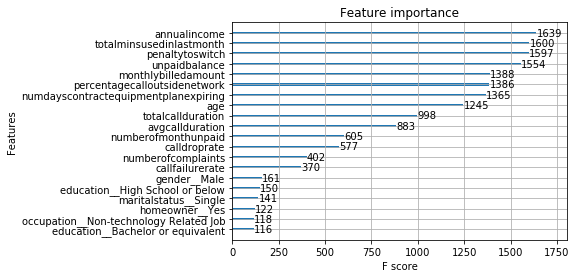

In [102]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(bst, max_num_features = 20)
pyplot.show()


#### Keras model

In [ ]:
ROC AUC: 0.736229  
Neg log loss: 0.281362 

In [248]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras.callbacks import EarlyStopping

import keras.backend as K
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train)
X_train_ker = ss.transform(X_train)
X_valid_ker = ss.transform(X_valid)

ker_model = Sequential()
ker_model.add(Dense(20, input_dim=77, activation='relu',kernel_initializer='uniform'))
ker_model.add(Dropout(0.5))
ker_model.add(Dense(10, activation='relu',kernel_initializer='uniform'))
ker_model.add(Dropout(0.5))
ker_model.add(Dense(10, activation='relu',kernel_initializer='uniform'))
ker_model.add(Dropout(0.5))
ker_model.add(Dense(1, activation='sigmoid',kernel_initializer='uniform'))
##model.add(Dense(output_dim=2, activation='softmax'))


early_stopping_monitor = EarlyStopping(patience=10)


## binary_crossentropy
ker_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

ker_model.fit(X_train_ker, y_train,
        callbacks=[early_stopping_monitor],
        validation_split = 0.25,
          epochs=500,
          batch_size=64,
             verbose = 2)

score = ker_model.evaluate(X_valid_ker, y_valid, batch_size=128)
print (score)

pred_proba = ker_model.predict_proba(X_train_ker)

print ("")
print ("ROC AUC: %f " % roc_auc_score(y_train,pred_proba))
print ("Neg log loss: %f " % log_loss(y_train,pred_proba))


pred_proba = ker_model.predict_proba(X_valid_ker)

print ("")
print ("ROC AUC: %f " % roc_auc_score(y_valid,pred_proba))
print ("Neg log loss: %f " % log_loss(y_valid,pred_proba))

Train on 10745 samples, validate on 3582 samples
Epoch 1/500
 - 6s - loss: 0.4940 - acc: 0.9080 - val_loss: 0.2937 - val_acc: 0.9112
Epoch 2/500
 - 1s - loss: 0.3439 - acc: 0.9091 - val_loss: 0.2890 - val_acc: 0.9112
Epoch 3/500
 - 1s - loss: 0.3360 - acc: 0.9091 - val_loss: 0.2865 - val_acc: 0.9112
Epoch 4/500
 - 1s - loss: 0.3348 - acc: 0.9091 - val_loss: 0.2854 - val_acc: 0.9112
Epoch 5/500
 - 1s - loss: 0.3199 - acc: 0.9091 - val_loss: 0.2841 - val_acc: 0.9112
Epoch 6/500
 - 1s - loss: 0.3162 - acc: 0.9091 - val_loss: 0.2832 - val_acc: 0.9112
Epoch 7/500
 - 1s - loss: 0.3147 - acc: 0.9091 - val_loss: 0.2829 - val_acc: 0.9112
Epoch 8/500
 - 1s - loss: 0.3129 - acc: 0.9091 - val_loss: 0.2820 - val_acc: 0.9112
Epoch 9/500
 - 1s - loss: 0.3125 - acc: 0.9091 - val_loss: 0.2820 - val_acc: 0.9112
Epoch 10/500
 - 1s - loss: 0.3039 - acc: 0.9091 - val_loss: 0.2819 - val_acc: 0.9112
Epoch 11/500
 - 1s - loss: 0.3057 - acc: 0.9091 - val_loss: 0.2801 - val_acc: 0.9112
Epoch 12/500
 - 1s - loss